In [1]:
!pip install torch==1.10.0+cu111 torchvision==0.11.0+cu111 torchaudio==0.10.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 GB 638.6 kB/s eta 0:00:000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.9/21.9 MB 23.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 26.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0
    Uninstalling torch-1.11.0:
      Successfully uninstalled torch-1.11.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0
    Uninstalling torchvision-0.12.0:
      Successfully uninstalled torchvision-0.12.0
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.11.0
    Uninstalling torchaudio-0.11.0:
      Successfully uninstalled torchaudio-0.11.0


In [2]:
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu110/torch1.7/index.html
!python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html

torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 11.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.0/131.0 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 KB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.0/79.0 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 KB 10.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.4/147.4 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 KB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Create

In [3]:
!nvidia-smi
!nvcc --version

import torch
print(torch.__version__)
import torchvision
print(torchvision.__version__)

Tue May 17 19:27:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Импорт библиотек и загрузка датасетов

In [4]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [5]:
from shapely.geometry import Polygon
import csv
from pathlib import Path

def calculate_detection_result(markup, answer):
    well_detected = 0
    IOU_THRESHOLD = 0.5
    for (k, v) in answer.items():
        a = Polygon(v[1])
        b = Polygon(markup[k][1])
        iou = a.intersection(b).area / a.union(b).area
        if iou > IOU_THRESHOLD:
            well_detected += 1
    return well_detected / len(markup)
    
    
def read_file(path):
    markup = {}
    with open(path, 'r', encoding='utf-16') as fd:
        rd = csv.reader(fd)
        next(rd)
        for row in rd:
            id = row[0]
            value = row[1]
            points = [(int(row[i]), int(row[i + 1])) for i in range(2, 10, 2)]
            markup[id] = [value, points]
    return markup


def calculate_accuracy(markup, answer):
    counter = 0
    for (k, v) in answer.items():
        markup_value = markup[k][0]
        if markup_value == v[0]:
            counter += 1
    return counter / len(markup)


ACCURACY_WEIGHT = 0.65
IOU_WEIGHT = 0.35


def evaluate(gt_path, answer_path):
    print(f"Checking answer ({answer_path}) against markup({gt_path})")
    markup = read_file(gt_path)
    answer = read_file(answer_path)
    recognition_accuracy = calculate_accuracy(markup, answer)
    print("recognition_accuracy=", recognition_accuracy)
    detection_result = calculate_detection_result(markup, answer)
    print("detection_result=", detection_result)
    score = ACCURACY_WEIGHT * recognition_accuracy + IOU_WEIGHT * detection_result
    print("score=", score)

In [6]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
# from google.colab.patches import cv2_imshow
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [7]:
DATASET_PATH = Path('/kaggle/input/barcode-dataset')
assert DATASET_PATH.exists(), DATASET_PATH.absolute()

### Подготовка модели

In [8]:
MODEL = 'COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml'

In [9]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file(MODEL))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL)
predictor = DefaultPredictor(cfg)

model_final_997cc7.pkl: 313MB [00:08, 38.0MB/s]                              


In [10]:
!ls /kaggle/input/barcode-dataset/Train/Train/

Images	Inverted  markup.csv  markup_wo_inverted.csv


In [11]:
!ls /kaggle/input/barcode-dataset/Test/Test/

Images


In [12]:
img = cv2.imread('/kaggle/input/barcode-dataset/Train/Train/Images/0a0ece21b249cc777ecd6835227a74a5.png')
preds = predictor(img)

/opt/conda/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/opt/conda/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


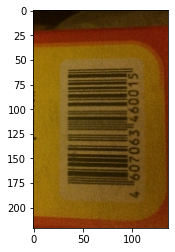

In [13]:
v = Visualizer(img, MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.1)
out = v.draw_instance_predictions(preds["instances"][preds["instances"].scores >= 0.4].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])

### Подготовка датасета

In [14]:
c = 0
for root, dirs, files in os.walk(DATASET_PATH / 'Train/Train/Images'):
    for name in files:
        print(name)
        c += 1
        if c == 10:
            break

b9f54e9eefecf79bb0518bc4b485d23d.png
1ca31df6d826717154243ee51dcd2582.png
ec9f26aac0734e920fb3b3a1e87e6bb4.png
10f4b48e5e4aa438109ae950bfae9a2c.png
8255e1e498791a36b4a5dac75b560ad2.png
60a9be5b1be21eabe4f932275d895359.png
0c44b59f34e66706c2eeee63d74d226d.png
eca782de689919a8ad40928f816694c1.png
ba555750e055f1c858f233fe9b044a8e.png
d6d36216b2c68a7f934adcd3ee10400e.png


In [15]:
columns = ["img", "num", "x1", "y1", "x2", "y2", "x3", "y3", "x4", "y4", "modules"]
annotations = pd.read_csv(DATASET_PATH / 'Train/Train/markup.csv', encoding="utf_16", names=columns)
annotations

,img,num,x1,y1,x2,y2,x3,y3,x4,y4,modules
0,fc272e4092ccb147a31e66bc1d10fbfb.png,3601514743345,538,248,1590,225,1597,663,532,676,1010101111000110101100110111001011001101000110...
1,8cde8cb1b54bca37c9347baf74157d22.png,7000001062307,372,433,360,1289,124,1293,147,431,1010001101010011100011010100111000110101100110...
2,70a9be0887eae17eabd70c8e607f963f.png,2250001407126,408,230,1224,229,1224,688,414,683,1010010011011000101001110100111000110101100110...
3,a029e49dff95a15d2cd396d8f62220c8.png,10101427156,335,149,1005,155,1005,438,335,447,1010001101001100100011010011001000110100110010...
4,82ff01909b6d215170dfc26c7be43074.png,2400745402226,469,237,1388,260,1392,712,464,696,1010100011000110101001110010001010001101110010...
...,...,...,...,...,...,...,...,...,...,...,...
8194,c532771808e76e333ba9e959853886f3.png,4823077510083,86,54,622,53,622,202,87,202,1010110111001101101111010001101001000100100010...
8195,186338ad8f3ff17b6082c023f24563f0.png,4823077505386,109,44,664,55,668,206,107,192,1010110111001101101111010001101001000100100010...
8196,5bac8f6c9bd5e99f92eb396442974c4e.png,4823077505492,121,27,704,13,704,168,120,187,1010110111001101101111010001101001000100100010...
8197,6247db3e424148a859ebf2180f1dcb6f.png,2010000019696,158,81,165,518,62,521,55,82,1010001101001100101001110100111000110101001110...


In [16]:
inverted = pd.read_csv(DATASET_PATH / 'Train/Train/Inverted/markup.csv', encoding="utf_16", names=columns)
inverted_set = set(inverted.loc[:, 'img'])
len(inverted_set)

49

In [17]:
annotations[annotations['img'] == 'fc272e4092ccb147a31e66bc1d10fbfb.png'].iloc[0, 2:10].values

array([538, 248, 1590, 225, 1597, 663, 532, 676], dtype=object)

In [18]:
annotations[annotations['img'] == 'c532771808e76e333ba9e959853886f3.png']

,img,num,x1,y1,x2,y2,x3,y3,x4,y4,modules
8194,c532771808e76e333ba9e959853886f3.png,4823077510083,86,54,622,53,622,202,87,202,1010110111001101101111010001101001000100100010...


In [19]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode

def get_dicts(dataset_path, train_set=True):
    subfolder = 'Train/Train/Images' if train_set else 'Test/Test/Images'

    dataset_dicts = []
    for root, dirs, files in os.walk(dataset_path / subfolder):
        for name in files:
            if name in inverted_set:
                continue

            record = {}
            img_path = str(dataset_path / subfolder / name)
            img = cv2.imread(img_path)
            height, width, channels = img.shape
            record['file_name'] = img_path
            record['image_id'] = name
            record['height'] = height
            record['width'] = width
              
            try:
                img_points = annotations[annotations['img'] == name].iloc[0, 2:10].values
            except:
                print(f"No annotations found for {name}, skipping...")
                continue
            xs = []
            ys = []
            
            keypoints = []
            for i in range(0, 8, 2):
                x = img_points[i]
                xs.append(x)
                y = img_points[i + 1]
                ys.append(y)
                visible = 2 if 0 <= x <= width and 0 <= y <= height else 0
                if visible == 2:
                    keypoints.extend([x, y])
                else:
                    keypoints.extend([0, 0])
                keypoints.append(visible)

            max_x = max(xs)
            min_x = min(xs)
            max_y = max(ys)
            min_y = min(ys)

            w = max_x - min_x
            h = max_y - min_y

            box = [min_x, min_y, w, h]

            obj = {
                'bbox': box,
                'bbox_mode': BoxMode.XYWH_ABS,
                'keypoints': keypoints,
                'category_id': 0,
            }

            record['annotations'] = [obj]
            dataset_dicts.append(record)

    return dataset_dicts

for d in ['train', 'val']:
    DatasetCatalog.register('bc_' + d, lambda d = d: get_dicts(DATASET_PATH, train_set = d == 'train'))
    MetadataCatalog.get('bc_' + d).set(thing_classes = ['bc'], 
                                       keypoint_names = ['1', '2', '3', '4'],
                                       keypoint_flip_map = [('1', '2'), ('3', '4')])
    
text_metadata = MetadataCatalog.get('bc_train')

In [ ]:
dataset_dicts = get_dicts(DATASET_PATH, train_set=True)

In [ ]:
for _ in range(3):
    pic = random.choice(dataset_dicts)
    if not pic['annotations']:
        continue
    img = cv2.imread(pic['file_name'])
    visualizer = Visualizer(img, metadata=text_metadata, scale=3.0)
    out = visualizer.draw_dataset_dict(pic)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

In [ ]:
pic

### Запуск тренировки

In [20]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(MODEL))
cfg.DATASETS.TRAIN = ("bc_train",)
cfg.DATASETS.TEST = ("bc_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL)
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.LR_POLICY = 'steps_with_decay'
cfg.SOLVER.BASE_LR = 0.01
cfg.SOLVER.MAX_ITER = 3000
cfg.SOLVER.STEPS = [1000, 2000]
cfg.SOLVER.GAMMA = 0.1
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 4
cfg.MODEL.ROI_KEYPOINT_HEAD.LOSS_WEIGHT = 1
cfg.INPUT.RANDOM_FLIP = "none"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

Логов обучения нет, так как kaggle не смог сохранить output ячеек в ноутбуке из-за ошибки, заново обучение лишь для получения логов я запускать не стал, так как это заняло бы более 3 часов.

In [ ]:
from IPython.display import FileLink, FileLinks
FileLink(r'./output/model_final.pth')

In [ ]:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(MODEL))
cfg.DATASETS.TRAIN = ("id_train",)
cfg.DATASETS.TEST = ("id_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "/kaggle/input/idcardsmodel/model_final.pth"
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.LR_POLICY = 'steps_with_decay'
cfg.SOLVER.BASE_LR = 0.0003
cfg.SOLVER.MAX_ITER = 1500
cfg.SOLVER.STEPS = [1000]
cfg.SOLVER.GAMMA = 0.5
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 4
cfg.MODEL.ROI_KEYPOINT_HEAD.LOSS_WEIGHT = 1
cfg.INPUT.RANDOM_FLIP = "none"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

### Оценка модели

In [23]:
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.WEIGHTS = "/kaggle/input/barcodelocmodel/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9
predictor = DefaultPredictor(cfg)

In [24]:
img = cv2.imread(str(DATASET_PATH / 'Test/Test/Images/5825c9d1deb6572b6dba440d5c6482bf.png'))
preds = np.array(predictor(img)['instances'].pred_keypoints.cpu())
preds = preds[0][:4, :2]
preds

/opt/conda/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/opt/conda/lib/python3.7/site-packages/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_int = (pos - x_int) // w


array([[ 567.9898 ,  465.78894],
       [1647.3019 ,  465.78894],
       [1696.9773 , 1356.7673 ],
       [ 567.9898 , 1356.7673 ]], dtype=float32)

In [25]:
preds.astype(int).flatten().tolist()

[567, 465, 1647, 465, 1696, 1356, 567, 1356]

In [26]:
answer = pd.read_csv("/kaggle/input/barcodegt/markup.csv", encoding="utf_16", names=columns)
answer.iloc[:, 1:] = 404
answer.head()

,img,num,x1,y1,x2,y2,x3,y3,x4,y4,modules
0,5825c9d1deb6572b6dba440d5c6482bf.png,404,404,404,404,404,404,404,404,404,404
1,f9bf5d96a0cf5d64aac4eb5806554224.png,404,404,404,404,404,404,404,404,404,404
2,a154b624c06072da1a01c97ebc3894c1.png,404,404,404,404,404,404,404,404,404,404
3,749003091876fc58be69db54bbaae8f1.png,404,404,404,404,404,404,404,404,404,404
4,560ca4ac1260313eb5979140c4f9ef31.png,404,404,404,404,404,404,404,404,404,404


In [27]:
for root, dirname, filenames in os.walk(DATASET_PATH / 'Test/Test/Images'):
    for filename in filenames:
        filepath = os.path.join(root, filename)
        img = cv2.imread(filepath)
        preds = np.array(predictor(img)['instances'].pred_keypoints.cpu())
        preds = preds[0][:4, :2]
        answer.loc[answer["img"] == filename, "x1":"y4"] = preds.astype(int).flatten().tolist()

/opt/conda/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/opt/conda/lib/python3.7/site-packages/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_int = (pos - x_int) // w


In [28]:
answer.to_csv("answer.csv", header=False, index=False, encoding="utf_16")

final_answer = pd.read_csv("answer.csv", encoding="utf_16")
final_answer.head()

,5825c9d1deb6572b6dba440d5c6482bf.png,404,567,465,1647,465.1,1696,1356,567.1,1356.1,404.1
0,f9bf5d96a0cf5d64aac4eb5806554224.png,404,673,441,1794,514,1794,1290,616,1115,404
1,a154b624c06072da1a01c97ebc3894c1.png,404,514,485,1559,313,1612,766,607,930,404
2,749003091876fc58be69db54bbaae8f1.png,404,522,267,1543,227,1543,636,522,666,404
3,560ca4ac1260313eb5979140c4f9ef31.png,404,578,247,1659,267,1659,722,1659,247,404
4,2bc877416a54aea8a94227ce9d1e5d1f.png,404,458,299,1384,272,1384,761,458,803,404


In [29]:
evaluate(gt_path="/kaggle/input/barcodegt/markup.csv", answer_path="answer.csv")

Checking answer (answer.csv) against markup(/kaggle/input/barcodegt/markup.csv)
recognition_accuracy= 0.0
detection_result= 0.9494949494949495
score= 0.3323232323232323


In [ ]:
FileLink(r'./answer.csv')

/opt/conda/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/opt/conda/lib/python3.7/site-packages/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_int = (pos - x_int) // w


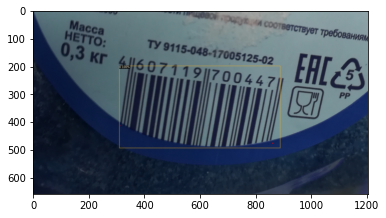

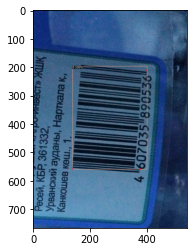

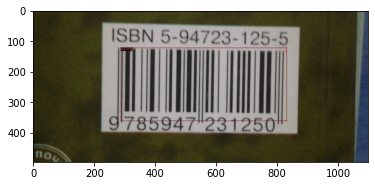

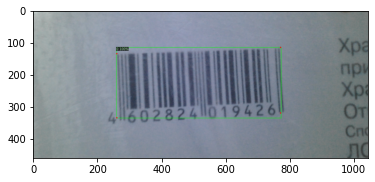

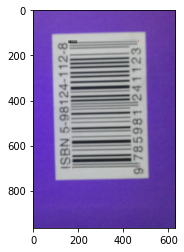

In [32]:
for root, dirname, filenames in os.walk(DATASET_PATH / 'Test/Test/Images'):
    for i, filename in enumerate(filenames):
        if i == 5:
            break
        filepath = os.path.join(root, filename)
        img = cv2.imread(filepath)
        outputs = predictor(img)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
        outputs = outputs["instances"].to("cpu")
        high_score_outputs = outputs[outputs.scores >= 0.75]
        v = Visualizer(img, metadata=MetadataCatalog.get('bc_valid'), scale=0.5)
        out = v.draw_instance_predictions(high_score_outputs)
        plt.imshow(out.get_image())
        plt.show()